### import packages

In [75]:
import numpy as np
from pathlib import Path
import json
import importlib
import sys
from PIL import Image
import matplotlib.pyplot as plt

### Set Output Path

In [76]:
output_path = r"c:/Users/Tobias/Documents/Masterarbeit_lokal/synthetic_pipeline/meshroom_data/Moving_GRAU5_5cam"

### loading reconstructed data and generation informations

In [77]:
# Define the evaluation_path by combining the output_path and "Evaluation" directory
evaluation_path = Path(output_path) / "Evaluation"
# Initialize an empty dictionary to store the read variables
variables = {}
# Open the cache.txt file located in the evaluation_path directory in read mode
with open((evaluation_path / "cache.txt"), 'r') as cache_file:
    # Iterate through each line in the file
    for line in cache_file:
        # Split each line by the colon ':' to separate variable name and value
        name, value = line.strip().split(":", 1)
        # Add the variable name and value pair to the variables dictionary after stripping whitespace
        variables[name.strip()] = value.strip()
# Access the read variables from the dictionary
project_name = variables.get("project_name", "")
image_dir = variables.get("image_dir", "")
obj_path = variables.get("obj_path", "")
# Load file path to the Blender and CloudCompare application
with open(Path.cwd() / "path_settings.json", "r") as data:
    app_paths = json.load(data)
blender_path = app_paths["blender_exe"]
cc_path = app_paths["cloudcompare_exe"]
# Print out the read variables
print("Read Variables:")
print("Project Name:", project_name)
print("Image Directory:", image_dir)
print("Blender Path:", blender_path)
print("OBJ Path:", obj_path)
# load generation informations
# Load standard parameters
params_file_path = Path(image_dir) / "params.json"
with open(params_file_path, 'r') as file:
    params = json.load(file)
focuspoint = params["cam"]["focuspoint"]
focal_length = params["cam"]["focal_length"]*10**(-3)
sensor_width = params["cam"]["sensor_size"][0]*10**(-3)
aspect_ratio = params["cam"]["sensor_size"][0] / params["cam"]["sensor_size"][1]

Read Variables:
Project Name: Moving_GRAU5_5cam
Image Directory: C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\blender_data\Moving_GRAU5_5cam
Blender Path: C://Program Files//Blender Foundation//Blender 4.0//blender.exe
OBJ Path: C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\objects\GRAU5\GRAU5_centered.obj


load data

#### plot reconstructed mesh

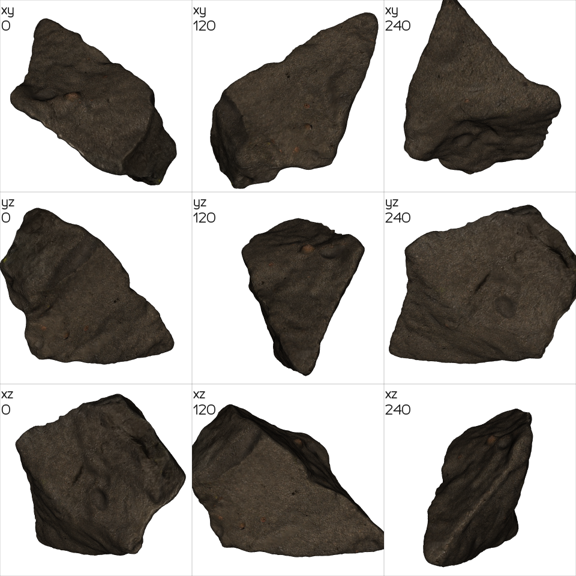

In [78]:
importlib.reload(sys.modules['src.plot_mesh_vedo']) if 'src.plot_mesh_vedo' in sys.modules else None
from src.plot_mesh_vedo import plot_mesh_vedo
fig,screenshot_path = plot_mesh_vedo(project_name,evaluation_path)
img = Image.open(screenshot_path)
scale = 0.6
display(img.resize(( int(img.width * scale), int(img.height * scale))))

### Postprocessing

#### Camera Location and Orientation

In [79]:
importlib.reload(sys.modules['src.CameraProcessing']) if 'src.CameraProcessing' in sys.modules else None
from src.CameraProcessing import read_camera_alignment_reconstruction, read_camera_alignment_reference, match_cameras, read_object_alignment, read_light_alignment
cams_rec = read_camera_alignment_reconstruction(output_path)
cams_ref = read_camera_alignment_reference(image_dir)
cams_rec, cams_ref  = match_cameras(cams_rec,cams_ref)
obj_moving = cams_rec[-1].TimeStep > 1 # moving object ? 
if obj_moving == True: objs, obj0 = read_object_alignment(image_dir)
lights = read_light_alignment(image_dir)   

#### Scaling factor

59 of 60 cameras could be reconstructed!
0 of 58 measured distances between camera pairs were detected as outliers (relative threshold: 7.0%)
0 Outlier Camera has been detected:


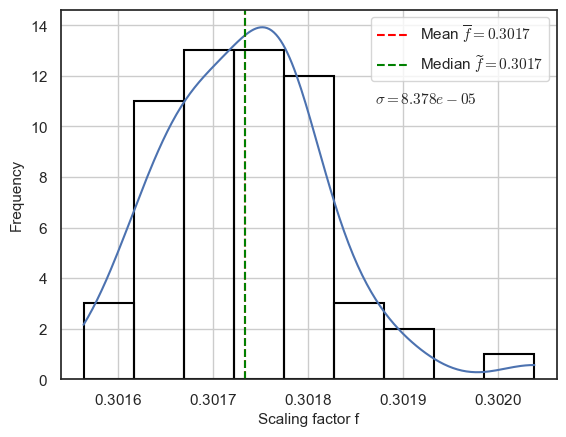

In [80]:
importlib.reload(sys.modules['src.scaling_factor']) if 'src.scaling_factor' in sys.modules else None
from src.scaling_factor import scaling_factor, scaling_factor_RANSAC
importlib.reload(sys.modules['src.TransMatrix_Utils']) if 'src.TransMatrix_Utils' in sys.modules else None
from src.TransMatrix_Utils import Scale2Transformation4x4
print(f"{len(cams_rec)} of {len(cams_ref)} cameras could be reconstructed!")
# criterion="abs","abs_norm" or "rel",     relative criterion: threshold = 0.07 --> 7%,    absolute normed criterion: threshold: 0.1m   --> measured on the scale of the reconstruction program --> ca. 2cm (real scale)
# absolute criterion: treshold: 0.1m
factor_mean, factor_median, factor_std, fig,_,_ = scaling_factor(cams_rec,cams_ref,evaluation_path,PreOutlierDetection=True,threshold = 0.07,criterion="rel") 
scaling = factor_median             # Set the scaling factor
T_scale = Scale2Transformation4x4(scaling)

In [81]:
importlib.reload(sys.modules['src.scaling_factor']) if 'src.scaling_factor' in sys.modules else None
from src.scaling_factor import scaling_factor, scaling_factor_RANSAC
# RANSAC doesn't make much sense for this application, especially for a small number of cameras (no hyperparameter tuning, no cross fitting done)
print(f"{len(cams_rec)} of {len(cams_ref)} cameras could be reconstructed!")
# criterion="rel" or "abs",     relative criterion: threshold = 0.07 --> 7%,    absolute normed criterion: threshold: 0.1m   --> measured on the scale of the reconstruction program --> ca. 2cm (real scale)
#f_ransac = scaling_factor_RANSAC(cams_rec,cams_ref,evaluation_path,PreOutlierDetection=True,threshold = 0.07,criterion = "rel") 

59 of 60 cameras could be reconstructed!


### Alignment of the reconstructed mesh with the ground truth

In [82]:
# Define file path to the mesh files
mesh_gt_path = obj_path                                                   # Path to ground truth mesh
mesh_r_path = evaluation_path / 'texturedMesh.obj'                        # Path to reconstructed mesh

#### Global Registration using open3d / Feature based alignment

In [83]:
ManualRegistration = False      
ThreePointRegistration = False

if ManualRegistration == False:
    importlib.reload(sys.modules['src.GlobalMeshRegistration']) if 'src.GlobalMeshRegistration' in sys.modules else None
    from src.GlobalMeshRegistration import GlobalMeshRegistration
    voxel_size = 1*10**(-3)
    draw_registration = 0 # choose 0,1,2,3,4 --> 0 = no plot appears --> 4 = all plots appears 
    T_global = GlobalMeshRegistration(mesh_r_path,mesh_gt_path,voxel_size,draw_registration,
                                    T_scale,ThreePointRegistration)
    T_global_path = evaluation_path / 'GlobalTransformationMatrix.txt'    # Define the file path for the saved transformation matrix
    np.savetxt(T_global_path,T_global)
else:
    T_global_path = evaluation_path / 'GlobalTransformationMatrix_manual.txt'    # Define the file path for the saved transformation matrix
    T_global = np.loadtxt(T_global_path)
#else: #Do It manually 
    # 1.) open CloudCompare
    # 2.) load texturedMesh (reconstructed) and the ground truth mesh (centered) 
    # 3.) deactivate normals on the ground truth mesh under Properties -> CC Object -> Normals
    # 4.) select both meshes by holding the control button. Important: First, select the ground truth mesh and then the reconstructed mesh 
    # 5.) scale the reconstructed mesh with the calculated scaling factor:
    #       - select the texturedMesh and go to edit -> Multiply/Scale --> enter the scaling factor and press Ok
    # 6.) Rotate the reconstructed Mesh (texturedMesh) with the Translate/Rotate Function in the top bar
    #   a) switch back and forth between the visibility of the objects and memorize distinctive spots on the ground truth mesh
    #   b) select the texturedMesh and use the Translate/Rotate Function
    #   c) rotate the texturedMesh so that the two meshes lie approximately on top of each other 
    # 7.) Finely Register the two Meshes
    #    a) select both meshes, click on the Finely Register Button on the top bar
    #    b) swap the meshes, if texturedMesh is not the "to be aligned"-Mesh
    #    c) click okay (disable adjust scale)
    # 8.) Export the Transformation Matrix
    #   a) select the texturedMesh.registered and export the transformation history under Properties --> Transformation history --> Export --> ASCII   
    #   b) save the File under "/../Evaluation/GlobalTransformationMatrix_manual.txt" 
    # 9.) Save the Registration inside a CloudCompare file 


# Idea: Compare coloured reconstructed and coloured reference point clouds. Optical texture comparison possible with a three-point method
# possibility to create a colorized (dense) point cloud in meshroom, looking for a programme that creates a point cloud from a textured mesh --> maybe cloudcompare

:: Downsample with a voxel size 0.001.
:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.
:: Downsample with a voxel size 0.001.
:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.001,
   we use a liberal distance threshold 0.002.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=4.545693e-04, and correspondence_set size of 3995
Access transformation to get result.


#### Fine Registration using CloudCompare / Iterative Closest Point (ICP) algorithm

In [84]:
# Set parameters
save_meshes_all_at_once = False                 # Save the transformed reconstructed mesh with the Groud_truth mesh in a single file (uses a lot of hard disk space)
silent = True                                   # No GUI pops up and no clicks necessary
adjust_scale = True                            # Alignment of the Mesh with SCALING
# Define output format for meshes
output_format_mesh = "OBJ"                                              # Format can be one of the following: BIN, OBJ, PLY, STL, VTK, MA, FBX.

# Function to align the reconstruected mesh and to calculate the Mesh to Mesh distance
importlib.reload(sys.modules['src.FineMeshRegistration_and_MeshToMeshDistance']) if 'src.FineMeshRegistration_and_MeshToMeshDistance' in sys.modules else None
from src.FineMeshRegistration_and_MeshToMeshDistance import FineMeshRegistration_and_MeshToMeshDistance
params_CC = [silent,save_meshes_all_at_once,adjust_scale,output_format_mesh]
T,T_ICP,mesh_r_trans_path,log_path = FineMeshRegistration_and_MeshToMeshDistance(cc_path,params_CC,evaluation_path,mesh_gt_path,mesh_r_path,output_format_mesh,T_global_path)

In [85]:
importlib.reload(sys.modules['src.TransMatrix_Utils']) if 'src.TransMatrix_Utils' in sys.modules else None
from src.TransMatrix_Utils import GetScaling_from_Transformation4x4
s_x,s_y,s_z = GetScaling_from_Transformation4x4(T_ICP)

# does not really make sense, as the volume ratio has the same information content

Scaling in X direction: 0.9993472123991702
Scaling in Y direction: 0.9993471849795309
Scaling in Z direction: 0.9993471815628415


### Cloud to Mesh: Mean Distance and Standard Deviation

In [86]:
# Reload the module 'read_c2m_distance_from_log' if it's already imported
importlib.reload(sys.modules['src.read_c2m_distance_from_log']) if 'src.read_c2m_distance_from_log' in sys.modules else None
from src.read_c2m_distance_from_log import read_c2m_distance_from_log
# Call the function to read mean distance and standard deviation from the log file
mean_distance, std_deviation = read_c2m_distance_from_log(log_path)

Cloud to Mesh Distance:
----------------------------------------
Global Mesh Registration
Mean distance: 1.38041e-05, Standard deviation: 0.000224864
--------------------
Closest Point Registration Procedure (ICP)
Mean distance: 3.62523e-06, Standard deviation: 5.55248e-05


### Comparison of volumes and surfaces

In [87]:
importlib.reload(sys.modules['src.EvaluateVolumeSurfaceArea']) if 'src.EvaluateVolumeSurfaceArea' in sys.modules else None
from src.EvaluateVolumeSurfaceArea import EvaluateVolumeSurfaceArea
EvaluateVolumeSurfaceArea(evaluation_path,mesh_gt_path,T_global,T)

Object                                          Volume (m^3)    Surface Area (m^2)    Sauter Diameter (mm)    Specific Surface Area (m^2/m^3)    Sphericity [-]
--------------------------------------------  --------------  --------------------  ----------------------  ---------------------------------  ----------------
Reconstructed Obj.                               1.11727e-05            0.00341883                 19.6079                            305.999          0.706933
Reconstructed Obj. (Scaling by CloudCompare)     1.11508e-05            0.00341437                 19.5951                            306.199          0.706933
Ground Truth                                     1.11395e-05            0.00359079                 18.6135                            322.347          0.671746


### Evaluation of the reconstructed Cameras

Calculate camera parameters in relation to the global coordinate system

In [88]:
for i, cam in enumerate(cams_rec): cam.Transformation2WorldCoordinateSystem(T,focuspoint)

Calculate camera positions in the dynamic (object is moving) and the static case (object is fixed)

In [89]:
for cam in cams_ref:
    if obj_moving: 
        Tdynamic2static = cam.Dynamic2StaticScene(objs[cam.CorrespondigIndexObject].Transformation, obj0.Transformation,focuspoint)
        if cam.CorrespondigIndex != None:
            cam_rec = cams_rec[cam.CorrespondigIndex]
            cam_rec.TransformationDynamic = np.linalg.inv(Tdynamic2static) @ cam_rec.TransformationStatic
    else:
        cam.TransformationDynamic = None    # delete Transformation Matrix of the dynamic case if the object is not moving

#### reference cameras

dynamic scene

initialize camera pose visualizer


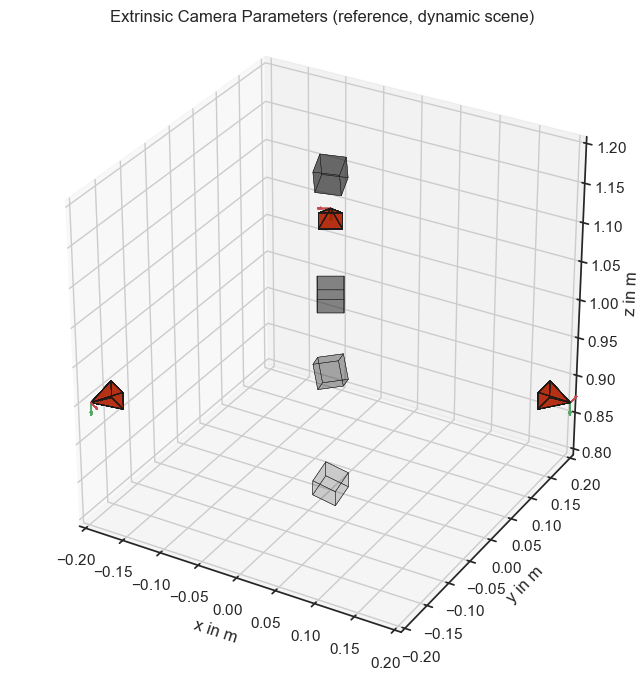

In [90]:
if obj_moving: 
    importlib.reload(sys.modules['src.camera_pose_visualizer']) if 'src.camera_pose_visualizer' in sys.modules else None
    from src.camera_pose_visualizer import CameraPoseVisualizer
    visualizer = CameraPoseVisualizer([-0.2, 0.2], [-0.2, 0.2], [0.8, 1.2])
    visualizer.load_cameras(cams_ref,focal_length,aspect_ratio,sensor_width,scale=2,alpha=0.05,DrawCoordSystem=True,colormap='gnuplot',static_scene=False,color_based_on_height=True)
    visualizer.load_cube(cams_ref)
    #visualizer.load_lights(lights)
    path = evaluation_path / "Extrinsics_cams_reference"
    visualizer.save(path)      
    visualizer.show('Extrinsic Camera Parameters (reference, dynamic scene)')

static scene

initialize camera pose visualizer


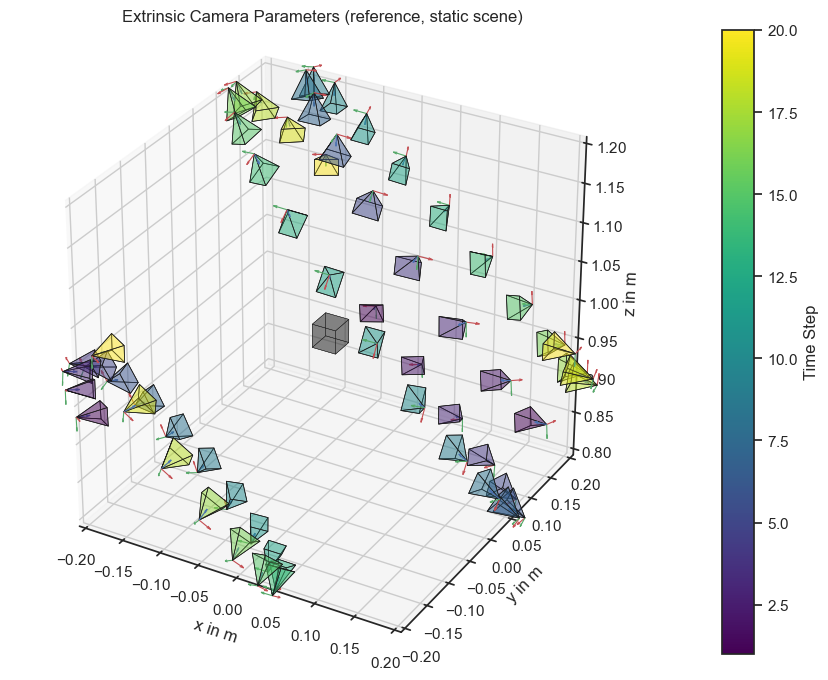

In [91]:
importlib.reload(sys.modules['src.camera_pose_visualizer']) if 'src.camera_pose_visualizer' in sys.modules else None
from src.camera_pose_visualizer import CameraPoseVisualizer 
visualizer2 = CameraPoseVisualizer([-0.2, 0.2], [-0.2, 0.2], [0.8, 1.2])
visualizer2.load_cameras(cams_ref,focal_length,aspect_ratio,sensor_width,scale=2,alpha=0.3,DrawCoordSystem=True,static_scene=True,colorbar=True) 
visualizer2.load_cube(cams_ref,static_scene=True)      
path = evaluation_path / "Extrinsics_cams_reference_static"
visualizer2.save(path)
visualizer.show('Extrinsic Camera Parameters (reference, static scene)')

Export the extrensic parameters of the cameras for subsequent import into Blender

In [92]:
importlib.reload(sys.modules['src.CameraProcessing']) if 'src.CameraProcessing' in sys.modules else None
from src.CameraProcessing import ExportCameras2Blender
ExportCameras2Blender(cams_ref,evaluation_path,static_scene=True)

#### Visual Comparison between reference and reconstructed cameras

static scene

initialize camera pose visualizer


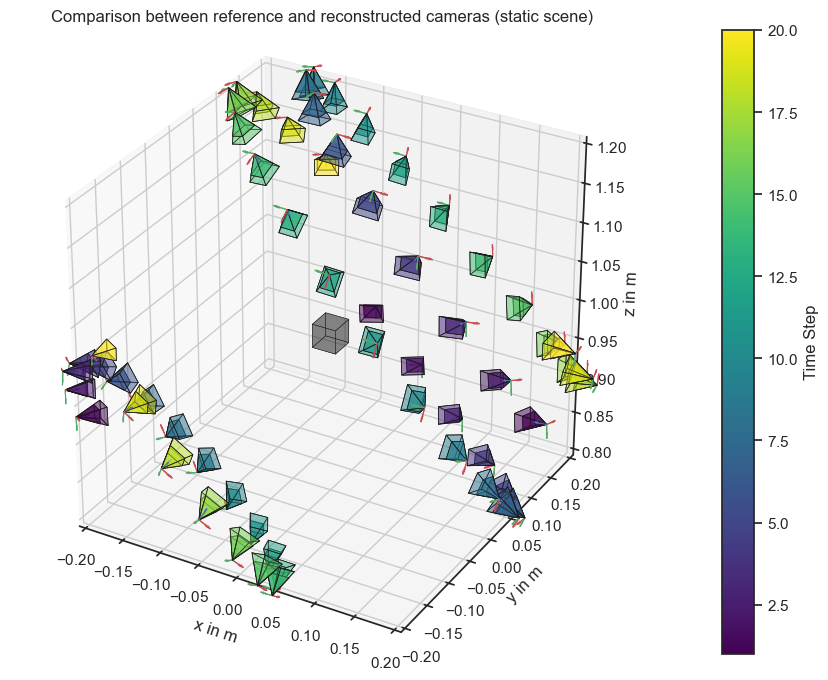

In [93]:
importlib.reload(sys.modules['src.camera_pose_visualizer']) if 'src.camera_pose_visualizer' in sys.modules else None
from src.camera_pose_visualizer import CameraPoseVisualizer
visualizer3 = CameraPoseVisualizer([-0.2, 0.2], [-0.2, 0.2], [0.8, 1.2])
visualizer3.load_cameras(cams_rec,focal_length,aspect_ratio,sensor_width,scale=2,alpha=0.3,DrawCoordSystem=True,colorbar = True,static_scene=True)
visualizer3.load_cameras(cams_ref,focal_length,aspect_ratio,sensor_width,scale=1.5,alpha=0.5,DrawCoordSystem=True,static_scene=True)
visualizer3.load_cube(cams_ref,static_scene=True)
path = evaluation_path / "Extrinsics_cams_comparison_static"
visualizer3.save(path)
visualizer3.show('Comparison between reference and reconstructed cameras (static scene)')      


In [94]:
#%matplotlib qt
#importlib.reload(sys.modules['thesis.PlotCamComparison']) if 'thesis.PlotCamComparison' in sys.modules else None
#from thesis.PlotCamComparison import PlotCamComparisonStatic
#PlotCamComparisonStatic(cams_ref,cams_rec,focal_length,aspect_ratio,sensor_width)

In [95]:
#importlib.reload(sys.modules['thesis.PlotCamComparison']) if 'thesis.PlotCamComparison' in sys.modules else None
#from thesis.PlotCamComparison import PlotCamComparisonDynamic
#%matplotlib qt
#PlotCamComparisonDynamic(cams_ref,cams_rec,focal_length,aspect_ratio,sensor_width)

In [96]:
#plt.switch_backend('module://ipykernel.pylab.backend_inline')

dynamic scene

initialize camera pose visualizer


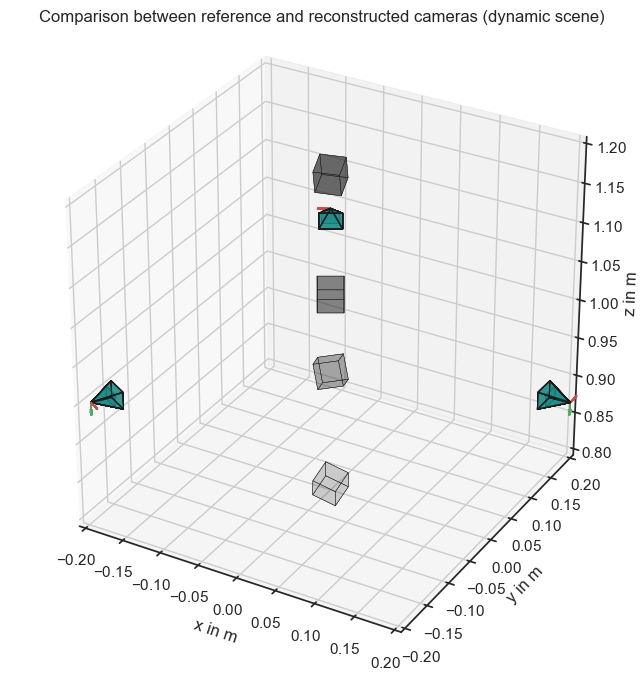

In [97]:
if obj_moving:
   importlib.reload(sys.modules['src.camera_pose_visualizer']) if 'src.camera_pose_visualizer' in sys.modules else None
   from src.camera_pose_visualizer import CameraPoseVisualizer
   visualizer4 = CameraPoseVisualizer([-0.2, 0.2], [-0.2, 0.2], [0.8, 1.2])
   visualizer4.load_cameras(cams_rec,focal_length,aspect_ratio,sensor_width,scale=2,alpha=0.05,DrawCoordSystem=True,static_scene=False,color_based_on_height=True)
   visualizer4.load_cameras(cams_ref,focal_length,aspect_ratio,sensor_width,scale=1.5,alpha=0.1,DrawCoordSystem=True,static_scene=False,color_based_on_height=True)
   visualizer4.load_cube(cams_ref,static_scene=False)
   path = evaluation_path / "Extrinsics_cams_comparison_dynamic"
   visualizer4.save(path) 
   visualizer4.show('Comparison between reference and reconstructed cameras (dynamic scene)')      
    

#### Quantitativ evaluation of the reconstructed camera positions

Create dataset

In [98]:
importlib.reload(sys.modules['src.CameraPositionEvaluation']) if 'src.CameraPositionEvaluation' in sys.modules else None
from src.CameraPositionEvaluation import CreateCameraDataSets
pos_x,pos_y,Rx,Ry = CreateCameraDataSets(cams_rec,cams_ref)

59 cameras from 60 cameras were reconstructed (98.33333333333333 %)


Comparison between the positions of the reconstructed cameras and the reference cameras

Mean absolute camera position error: 0.43mm
Mean relative camera position error: 0.14%
Standard deviation: 0.11mm
Number of Inliers: 59 (rel. error <= 0.5%)
Number of Outliers: 0 (rel. error > 0.5%)


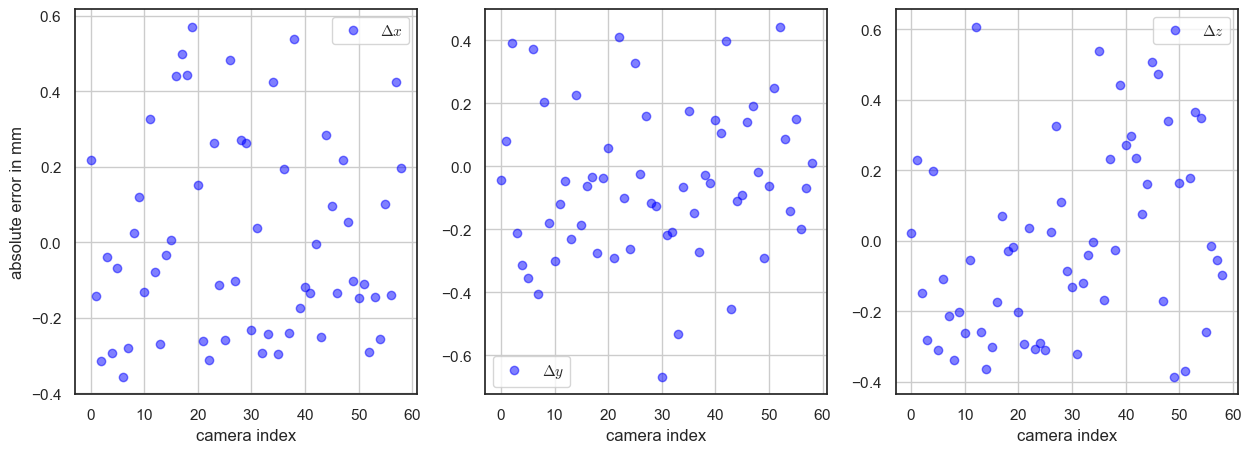

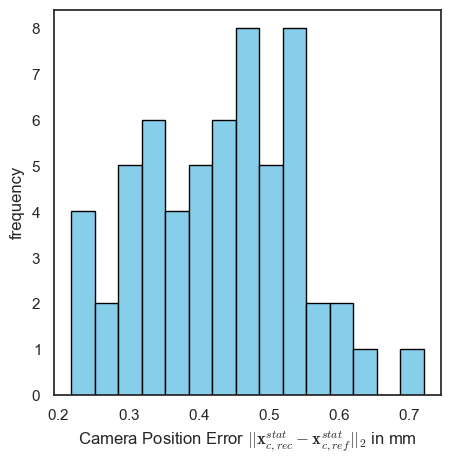

In [99]:
importlib.reload(sys.modules['src.CameraPositionEvaluation']) if 'src.CameraPositionEvaluation' in sys.modules else None
from src.CameraPositionEvaluation import PlotAbsPositionError_for_xyz, AbsPositionError
PlotAbsPositionError_for_xyz(pos_x,pos_y) 
AbsPositionError(pos_x,pos_y,outlier_criterion=0.005)

Comparison between the orientation of the reconstructed cameras and the reference cameras

Mean rotation difference: 0.11°
Standard deviation: 0.04°
Number of Inliers: 59 (angle error <= 1°)
Number of Outliers: 0 (angle error > 1°)


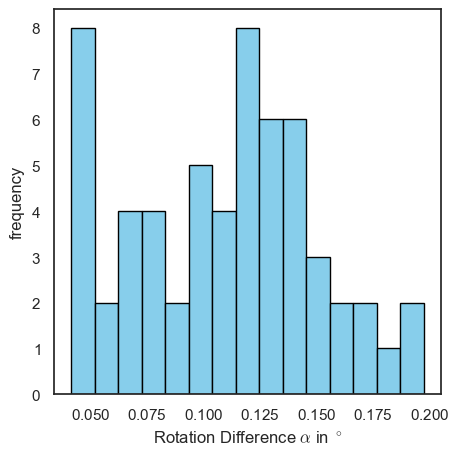

In [100]:
#don't know what i am exactly did here. @TODO: Control Calculation 
#--> calculate the smallest angle between the rotations using quaternions (should be semiliar to DOI:10.3390/jimaging4080098)
importlib.reload(sys.modules['src.CameraPositionEvaluation']) if 'src.CameraPositionEvaluation' in sys.modules else None
from src.CameraPositionEvaluation import OrientationError
OrientationError(Rx,Ry,outlier_criterion_angle = 1)

### Evaluation of the texture

generate images from the same perspective of the reconstructed and reference object! 

Since no known Python library is able to load the texture files (UDIM) of the reference object, the image creation is again done also in Blender

In [101]:
importlib.reload(sys.modules['src.TextureEvaluation']) if 'src.TextureEvaluation' in sys.modules else None
from src.TextureEvaluation import GetImagesForTextureEvaluation
OutputTextureRef_path = evaluation_path / "TextureReference"
OutputTextureRec_path = evaluation_path / "TextureReconstruction"
GetImagesForTextureEvaluation(obj_path,OutputTextureRef_path,params["io"]["script_path"],blender_path)
GetImagesForTextureEvaluation(mesh_r_trans_path,OutputTextureRec_path,params["io"]["script_path"],blender_path)

#### Grey Scale Co-Occurence Matrix 

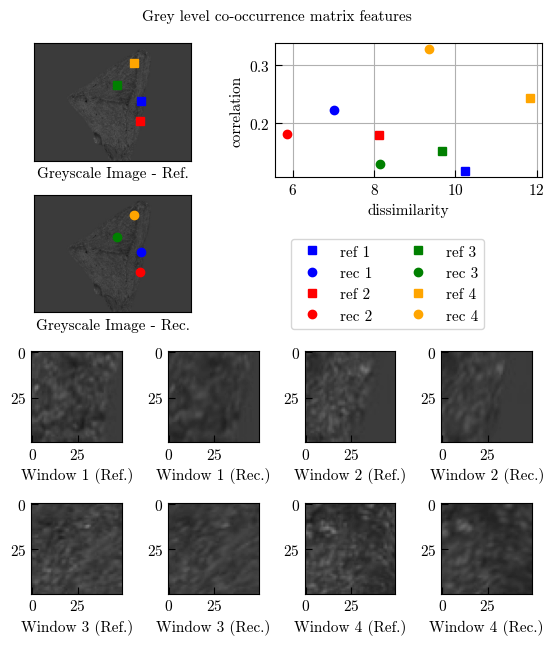

In [102]:
patch_size = 50
levels = 256; 
distances = 5
image_number = 2
features = ["dissimilarity","correlation"] # "contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"

importlib.reload(sys.modules['src.TextureEvaluation']) if 'src.TextureEvaluation' in sys.modules else None
from src.TextureEvaluation import GLCM_Evaluation
GLCM_Evaluation(evaluation_path,OutputTextureRef_path,OutputTextureRec_path,patch_size,image_number,levels,distances,random_seed=124,features = features,num_windows=4)

##### offset correction

Calculate mean offset in the GLCM-features

GLCM feature: dissimilarity
Root Mean Square Error (RMSE): 2.56
Relative Root Mean Square Error (RRMSE): 0.31
Mean Error: 2.35
Median Error: 2.24
Standard Deviation of Errors: 1.01
Coefficient of Variation of Errors: 0.43
-----------------------------
GLCM feature: correlation
Root Mean Square Error (RMSE): 0.08
Relative Root Mean Square Error (RRMSE): 3.51
Mean Error: -0.04
Median Error: -0.04
Standard Deviation of Errors: 0.07
Coefficient of Variation of Errors: -1.78
-----------------------------


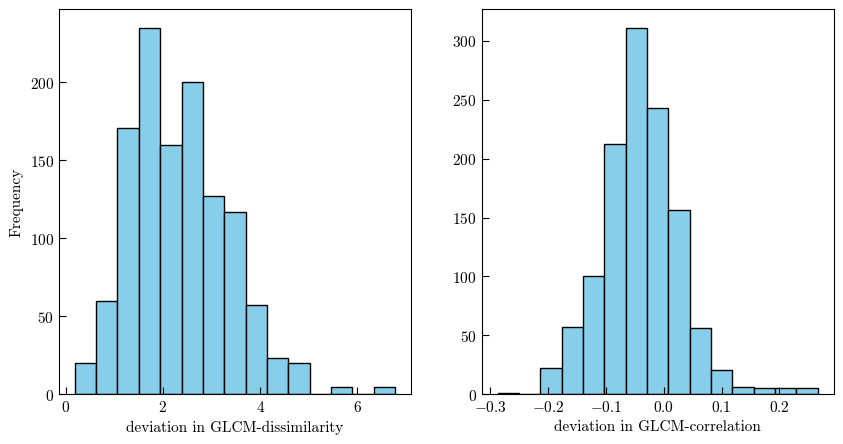

In [103]:
importlib.reload(sys.modules['src.TextureEvaluation']) if 'src.TextureEvaluation' in sys.modules else None
from src.TextureEvaluation import GLCM_feature_correlation
offset_method = "non-standardized" # "non-standardized", "relative"
mean, median = GLCM_feature_correlation(OutputTextureRef_path,OutputTextureRec_path,patch_size,levels,distances,features = features, offset_method = offset_method)

GLCM features after offset correction

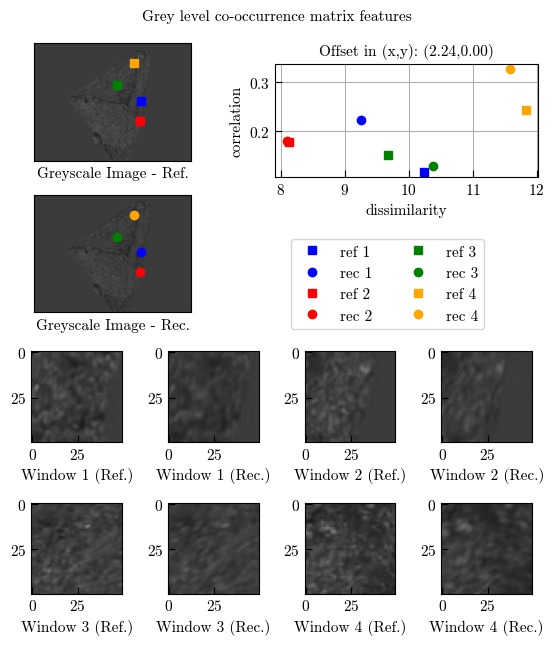

In [104]:
importlib.reload(sys.modules['src.TextureEvaluation']) if 'src.TextureEvaluation' in sys.modules else None
from src.TextureEvaluation import GLCM_Evaluation

#offset = [median[0],median[1]]
offset = [median[0],0]
GLCM_Evaluation(evaluation_path,OutputTextureRef_path,OutputTextureRec_path,patch_size,image_number,levels,distances,random_seed=124,features = features,num_windows=4, offset=offset, offset_method = offset_method)

GLCM statistics after offset correction

GLCM feature: dissimilarity
Offset: 2.24
Root Mean Square Error (RMSE): 1.02
Relative Root Mean Square Error (RRMSE): 0.10
Mean Error: 0.11
Median Error: 0.00
Standard Deviation of Errors: 1.01
Coefficient of Variation of Errors: 8.89
-----------------------------
GLCM feature: correlation
Root Mean Square Error (RMSE): 0.08
Relative Root Mean Square Error (RRMSE): 3.51
Mean Error: -0.04
Median Error: -0.04
Standard Deviation of Errors: 0.07
Coefficient of Variation of Errors: -1.78
-----------------------------


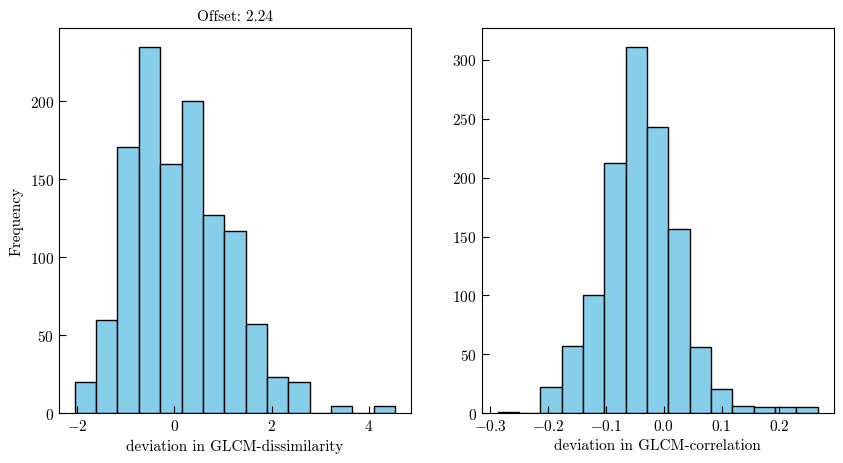

In [105]:
importlib.reload(sys.modules['src.TextureEvaluation']) if 'src.TextureEvaluation' in sys.modules else None
from src.TextureEvaluation import GLCM_feature_correlation
_, _ = GLCM_feature_correlation(OutputTextureRef_path,OutputTextureRec_path,patch_size,levels,distances,features = features, offset=offset, offset_method = offset_method)

too much smoothing inside MVS

- reduze Smoothing Iteratation within Mesh Filtering ?
- OutputTextureSize maximal ? (already realized)
- TextureDownscale minimal ?  (already realized)